In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

# Bayesian COVID-19 Classifier
In this task you will develop a simple COVID-19 Classifier based on Bayesian Networks.
For this, you should fill in the dots.

## Load Data
Here we will use a fragment of the dataset, which has been published alongside the paper ["Machine learning-based prediction of COVID-19 diagnosis based on symptoms" Yazeed Zoabi, Shira Deri-Rozov & Noam Shomron](https://www.nature.com/articles/s41746-020-00372-6).

It is a dataset with various symptoms and the associated COVID-19 test results.

First you need to load in the data from the `covid_symptoms_data.csv` supplied along with the exercise.



In [2]:
data = pd.read_csv('./covid_symptoms_data.csv')

There are 5 different syptoms considered in this dataset: `cough`, `fever`, `sore_throat`,	`shortness_of_breath`, `head_ache`. If the value is 1 then the symptom is present if 0 it is not. The `corona_result` column provides the result of the COVID-19 test. It can be either "*negative*", "*positive*" or "*other*". Here we are only interested in the "*negative*" and "*positive*" outcomes.
Let's clean up the dataset to only contain data that is relevant to our classification task.

In [3]:
# Filter the negative and positive results
clean_data = data.query('corona_result == "negative" or corona_result == "positive"')

# Change the negative and positive results into a boolean variable
clean_data['corona_result'] = clean_data['corona_result'].apply(lambda result: np.int0(result == "positive"))

symptoms = ['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache']

# Select only the columns that are relevant
clean_data = clean_data[symptoms + ['corona_result']]

clean_data

,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
55404,0,0,0,0,0,0
55405,0,0,0,0,0,0
55406,0,0,0,0,0,0
55408,0,0,0,0,0,0


## Split into train and test datasets

After loading and cleaning the data, we now have to split it into train and test data (ratio 10:1)

In [4]:
from sklearn.model_selection import train_test_split

# Split the data into train and test sets
train_data, test_data = train_test_split(clean_data, test_size=(1/11), random_state=42, stratify=clean_data['corona_result'])
# If ratio is 10:1 then the size of the test_data is 1/11 of the whole dataset
# Random state is introduced for reproducibility

# Take a look at randomly splitted data
train_data.head()

,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result
44191,0,0,0,0,0,0
36288,0,0,0,0,0,0
15524,0,0,0,0,0,0
20304,0,1,0,0,0,1
25367,0,0,0,0,0,0


In [5]:
# Confirm correct split ratio
print(f'Size of train_data: {len(train_data)}')
print(f'Size of test_data:  {len(test_data)}')
print(f'The split ratio has been implemented successfully!')

Size of train_data: 49527
Size of test_data:  4953
The split ratio has been implemented successfully!


## Compute the probabilities
Now using the training data compute the probabilities $p(C)$ and $p(s_i \mid C)$ from the data.

In [6]:
# Prior of covid test
p_covid = len(train_data[train_data['corona_result'] == 1]) / len(train_data)

# Likelihood of the symptoms given covid = 1
p_symptom_covid1 = {}
for symptom in symptoms:
    p_symptom_covid1[symptom] = len(train_data.query(f'{symptom} == 1 and corona_result == 1')) / len(train_data.query('corona_result == 1'))
    
# Likelihood of the symptoms given covid = 0
p_symptom_covid0 = {}
for symptom in symptoms:
    p_symptom_covid0[symptom] = len(train_data.query(f'{symptom} == 1 and corona_result == 0')) / len(train_data.query('corona_result == 0'))

# Evidence of the symptoms
p_symptom = {}
for symptom in symptoms:
    p_symptom[symptom] = len(train_data.query(f'{symptom} == 1')) / len(train_data)

In [7]:
print(f'Prior of covid test: {p_covid}\n')
print(f'Likelihood of the symptoms given covid:\n{p_symptom_covid1}\n')
print(f'Likelihood of the symptoms given no covid:\n{p_symptom_covid0}\n')
print(f'Evidence of the symptoms:\n{p_symptom}\n')

Prior of covid test: 0.08217739818684758

Likelihood of the symptoms given covid:
{'cough': 0.5017199017199018, 'fever': 0.48353808353808353, 'sore_throat': 0.1493857493857494, 'shortness_of_breath': 0.1339066339066339, 'head_ache': 0.22334152334152335}

Likelihood of the symptoms given no covid:
{'cough': 0.13386277141034383, 'fever': 0.06887828057284906, 'sore_throat': 0.01126339177684405, 'shortness_of_breath': 0.008689530765338672, 'head_ache': 0.01082341553556108}

Evidence of the symptoms:
{'cough': 0.16409231328366344, 'fever': 0.1029539443132029, 'sore_throat': 0.02261392775657722, 'shortness_of_breath': 0.018979546509984454, 'head_ache': 0.02828760070264704}



In [8]:
def likelihood_given_covid_state(symptom_set, corona):
    
    # Initialize list of values
    personal_probabilities = []
    
    # Choose dictionary given state of covid test
    if corona == True:
        dic = p_symptom_covid1
    else:
        dic = p_symptom_covid0
    
    # Store dictionary values in list
    probs = list(dic.values())
    
    # Check
    # print(f'Original probabilities:\n{probs}')
    
    # Replace probabilities with the given counterprobabilities, if not all symptoms are positive
    for value in range(len(symptom_set)):
        if symptom_set[value] == 1:
            personal_probabilities.append(probs[value])
        else:
            personal_probabilities.append(1-probs[value])
    
    # Check
    # print(f'Determined probabilities:\n{personal_probabilities}')
    
    # Product over the symptom probabilities given covid state
    likelihood = np.prod(personal_probabilities)
    
    return likelihood

In [9]:
def posterior_prob(symptom_set):
    
    # Compute posterior probability for set of symptoms, given corona = 1 !!
    Z = p_covid*likelihood_given_covid_state(symptom_set, corona=True) + (1-p_covid)*likelihood_given_covid_state(symptom_set, corona=False)
    post = p_covid*likelihood_given_covid_state(symptom_set, corona = True)/Z
    
    return post

In [10]:
posterior_prob(symptom_set = [0,0,0,0,0])

0.016581131923093177

## Compute the posterior for the data
Given the probabilites implement the posterior 
$$ p\left(C = 1 \mid \mathbf{S=s}\right) = \frac{p\left(C = 1\right)}{Z}\prod_{j=1}^5 p\left(S_j=s_j \mid C = 1\right),$$
where $Z$ is a normalizing factor of the form $Z = \sum_{i=0}^1 p\left(C = i\right)\prod_{j=1}^5 p\left(S_j=s_j \mid C = i\right)$.

In [11]:
X_train = train_data[symptoms].to_numpy()
y_train = train_data['corona_result'].to_numpy()

# Assign previously calculated dicts
p_s_c1 = p_symptom_covid1
p_s_c0 = p_symptom_covid0

# Predict individual probabilities by applying posterior function along set of rows
p_covid_symptoms_train = np.apply_along_axis(posterior_prob, axis=1, arr=X_train)

# Check
print(p_covid_symptoms_train)

[0.01658113 0.01658113 0.01658113 ... 0.58164154 0.01658113 0.01658113]


In [12]:
# Check that all values of posterior are between 0 and 1
if all(0 <= value <= 1 for value in p_covid_symptoms_train):
    print("All values are between 0 and 1!")
else:
    print("Warning: Not all values are between 0 and 1!")

All values are between 0 and 1!


If $P(C=1 \mid \mathbf{s}) > 0.5$ we assume that the patient is classified as positive for COVID-19. Get the classifications $y_{pred}$ for testing set $X_{test}$

In [13]:
X_test = test_data[symptoms].to_numpy()
y_test = test_data['corona_result'].to_numpy()

# Predict individual probabilities by applying posterior function along set of rows
p_covid_symptoms_test = np.apply_along_axis(posterior_prob, axis=1, arr=X_test)

# Make predicition based on probability
y_pred = np.asarray([1 if val > 0.5 else 0 for val in p_covid_symptoms_test]) # P(C = 1 | s) > 0.5 for X_test

In [14]:
# Check mean of predictions (predicted share of covid infected people)

# Compute share of positively tested people in test set
actual_share = len(test_data[test_data['corona_result'] == 1]) / len(test_data)

# Compare predicted to actual share
print(f'Predicted share of infected people (test): {np.mean(y_pred)}')
print(f'Actual share of infected people (test): {actual_share}')

Predicted share of infected people (test): 0.09388249545729861
Actual share of infected people (test): 0.08217242075509792


## Evaluate the accuracy
Verify the accuracy of this classifier on the test data.

\begin{equation}
ACC = \frac{\sum_{i=0}^N \mathbb{I}[y_{pred}^{(i)} = y_{test}^{(i)}]}{|y_{test}|},
\end{equation}
$\mathbb{I}[true] = 1$ and $\mathbb{I}[false] = 0$.

In [15]:
def accuracy(pred,test):
    correct = 0
    for i in range(len(pred)):
        if pred[i] == test[i]:
            correct +=1
    return correct/len(test)


acc = accuracy(y_pred,y_test)
print(acc)

0.9026852412679184


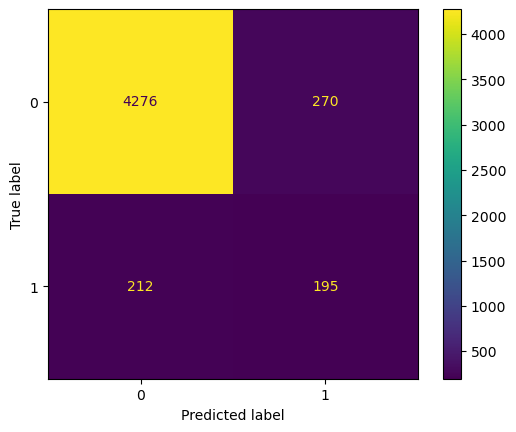

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm =confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

0.9178275792449021


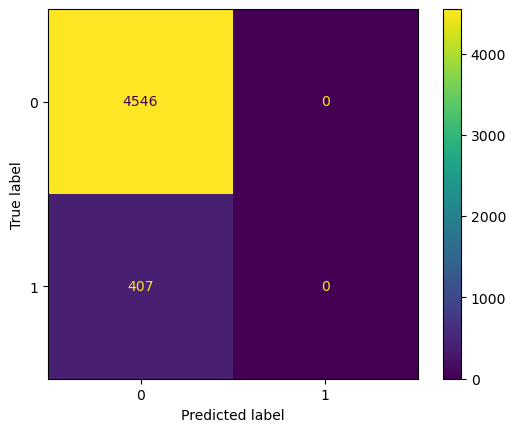

In [17]:
# Evaluate prediction, if we always predict covid_test = 0

# Define prediction list will all 0
y_pred_0 = np.zeros(len(y_pred))

cm =confusion_matrix(y_test, y_pred_0)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

acc = accuracy(y_pred_0,y_test)
print(acc)

#### Questions
- What do you observe when evaluating the classifier?
- How well does this classifier perform and why?
- What could you do to improve the classifier?

Your Answers:

# Answers

1. What do you observe when evaluating the classifier?
We observe that the classifier has a relatively high accuracy of roughly 90%, which is better than coinflipping or guessing randomly (approximately 50% accuracy). The confusion matrix displays a high number of true-negative predictions, while all other values are roughly around 200. 

2. How well does this classifier perform and why?
The classifier performs quite badly, since we would obtain a higher accuracy, if we simply predicted corona_test = 0 all the time. This would lead to an increase of accuracy of around 1.5%-points. We can also see that if the the observed person is positive, the prediction of our model is almost 50/50 and predicts 0 52% of the time and predicts 1 48% of the time. Thereofor, we can say that our classifier is rather good in predicting the test outcome, if the test is actually negative. On the other hand, the predictions are very bad if the test is actually positive.

This problem could occur, due to the fact that a large share of the data contains negative test results, therefore we have a very imbalanced dataset. 

3. What could you do to improve the classifier?
